In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib import colors
import os
import dispersion_utils as utils
import sys

In [3]:
years = np.arange(2010,2022)
months = [str(x).zfill(2) for x in range(1,13)]


home_folder = "/nethome/manra003/analysis/dispersion/simulations/"
output_folder = "/nethome/manra003/analysis/dispersion/outputs/"

# year=2017
# month=months[5]
# ds1 = xr.open_zarr(home_folder + '{0}/{1}/Benguela_{0}_1ov32_641x_321yres_{1}-{2}_5z_100days.zarr'.format(mode, year, month))
# ds1.z.isel(obs=99).plot(figsize=(8,8))


In [4]:
model_mask_file = '/storage/shared/oceanparcels/input_data/NEMO16_CMCC/GLOB16L98_mesh_mask_atlantic.nc'

mask_ds = xr.open_dataset(model_mask_file, decode_times=False).load()

mask_lon = mask_ds['glamf'].values
mask_lat = mask_ds['gphif'].values
mask_land = mask_ds['tmask'].values[:,:,:,:]

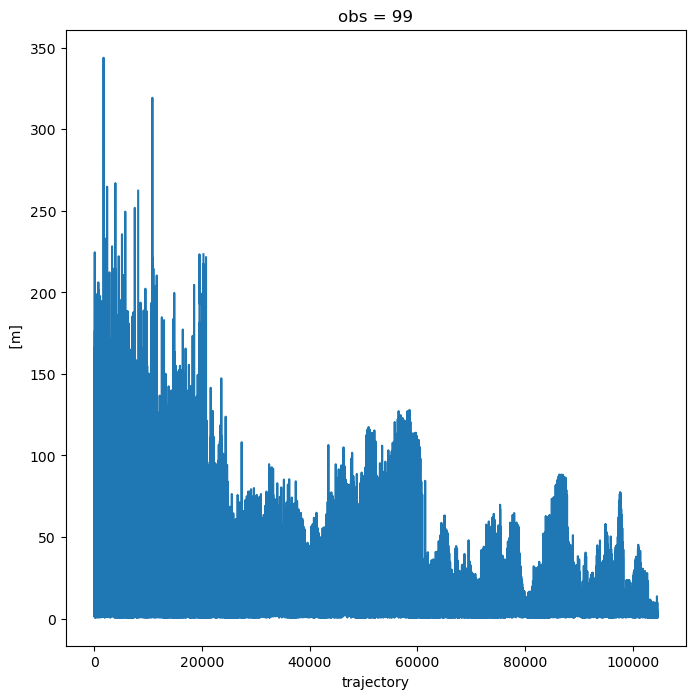

In [6]:
year=2017
month=months[5]
mode='3D'
ds1 = xr.open_zarr(home_folder + '{0}/{1}/Benguela_{0}_1ov32_641x_321yres_{1}-{2}_5z_100days.zarr'.format(mode, year, month))
ds1.z.isel(obs=99).plot(figsize=(8,8))

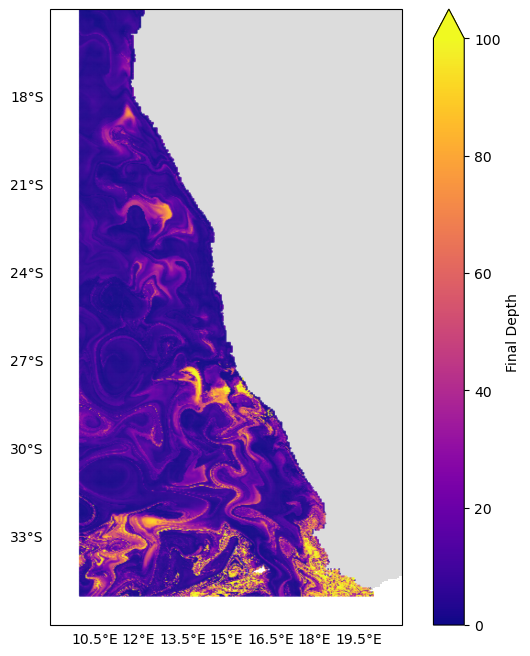

In [20]:
custom_size=10
fig = plt.figure(figsize=(8,8), dpi=100)
ax = plt.axes(projection=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True)
gl.xlines = False
gl.ylines = False
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': custom_size, 'color': 'k'}
gl.ylabel_style = {'size': custom_size, 'color': 'k'}

colormap = colors.ListedColormap(['gainsboro', 'white'])

# Near Amazon river- 4-5 month simulations
ax.pcolormesh(mask_lon[0, 1249:1750, 1499:], mask_lat[0, 1249:1750, 1499:], mask_land[0, 0,1250:1750, 1500:], cmap=colormap)
ax.set_xlim(9, 21)
ax.set_ylim(-36, -15)
im=ax.scatter(ds1['lon'][:,0].values, ds1['lat'][:,0].values, c=ds1['z'][:,99].values, cmap="plasma", vmin=0, vmax=100,s=0.1)
cbar=fig.colorbar(im, ax=ax, label='Final Depth', extend='max')
plt.show()


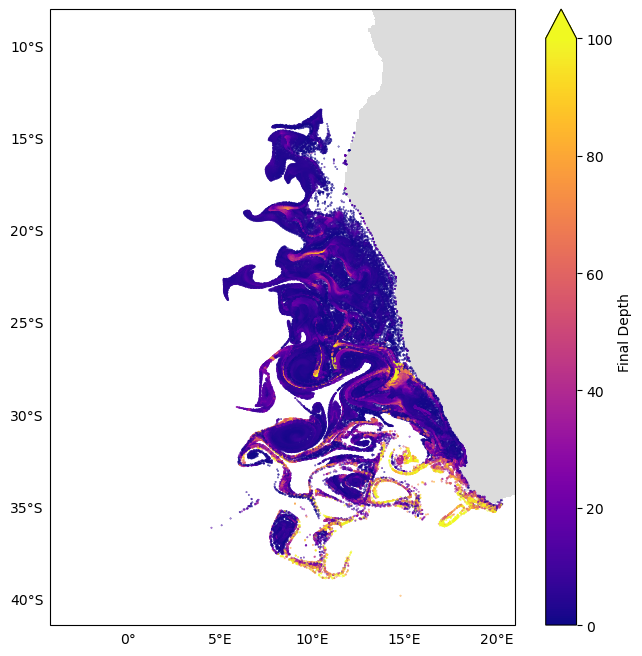

In [8]:
custom_size=10
fig = plt.figure(figsize=(8,8), dpi=100)
ax = plt.axes(projection=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True)
gl.xlines = False
gl.ylines = False
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': custom_size, 'color': 'k'}
gl.ylabel_style = {'size': custom_size, 'color': 'k'}

colormap = colors.ListedColormap(['gainsboro', 'white'])

# Near Amazon river- 4-5 month simulations
ax.pcolormesh(mask_lon[0, 1249:1750, 1499:], mask_lat[0, 1249:1750, 1499:], mask_land[0, 0,1250:1750, 1500:], cmap=colormap)
# ax.set_xlim(9, 21)
# ax.set_ylim(-36, -15)
im=ax.scatter(ds1['lon'][:,50].values, ds1['lat'][:,50].values, c=ds1['z'][:,99].values, cmap="plasma", vmin=0, vmax=100,s=0.1)
cbar=fig.colorbar(im, ax=ax, label='Final Depth', extend='max')
plt.show()


separate particles with final depth larger than a specific depth- for eg- 50m or 65m (ekamn depth from a paper)

In [3]:
depth_sep = 50

# indices=np.where(ds1.z.isel(obs=99)>depth_sep)[0]
# print(len(indices))
# print(len(indices)/len(ds1.z.isel(obs=0))*100)


In [37]:
# full_indices=np.arange(0,104636)
# mask=np.ones(full_indices.shape, dtype=bool)
# mask[indices]=False
# shallow_indices = full_indices[mask]
# len(shallow_indices)

97020

In [4]:

def get_separation_array(ds1, ds2, p_total, t_days):
    '''
    Method to get per particle pair distance between two types for each day opf the simulation
    parameters: ds1, ds2-two datasets; p_total-total number of particles; t_days-total number of outputs(per day) in the simulation 
    return: an array with horizontal separation distance between two types of particles for the same release.
    '''
    sep_array_1_2 = np.empty((p_total, t_days))
    sep_array_1_2[:] = np.nan
    for time_step in range(t_days):
        sep_array_1_2[:, time_step] = utils.distance(ds1['lon'][:, time_step], ds1['lat'][:, time_step], ds2['lon'][:, time_step], ds2['lat'][:, time_step])
    return sep_array_1_2


p_total= 104636
t_days = 100
threshold_dist = 100
all_sep_array = np.empty((p_total, t_days, len(months)))
all_CDFs = np.zeros((len(months), t_days+1))
shallow_all_CDFs = np.zeros((len(months), t_days+1))
deep_all_CDFs = np.zeros((len(months), t_days+1))

dvm_mode = '2D'
mode = '3D'

distance_folder = output_folder + "Distances/{0}-{1}/".format(dvm_mode, mode)
if not os.path.exists(distance_folder):
    os.makedirs(distance_folder)
cdf_folder = output_folder + "CDF/{0}-{1}/".format(dvm_mode, mode)
if not os.path.exists(cdf_folder):
    os.makedirs(cdf_folder)

full_indices = np.arange(0,p_total)
deep_count = np.zeros((len(years),len(months)))

for row_index, year in enumerate(years):
    print("Summary {0}-{1} for all months: {2}".format(dvm_mode, mode, year))

    shallow_all_CDFs = np.zeros((len(months), t_days+1))
    deep_all_CDFs = np.zeros((len(months), t_days+1))
   
    for index, month in enumerate(months):
    # Get monthly CDF from 100 days simulation.
        ds2 = xr.open_zarr(home_folder + '{0}/{1}/Benguela_{0}_1ov32_641x_321yres_{1}-{2}_5z_100days.zarr'.format(mode, year, month))

        all_sep_array = np.load(distance_folder + "all_sep_array_{0}_{1}_{2}_tc{3}km.npy".format(dvm_mode, mode, year, threshold_dist))
        deep_indices = np.where(ds2.z.isel(obs=99)>depth_sep)[0]

        deep_count[row_index,index] = len(deep_indices)

        mask = np.ones(full_indices.shape, dtype=bool)
        mask[deep_indices] = False
        shallow_indices = full_indices[mask]

        shallow_all_CDFs[index, :], _ = utils.get_diff_CDF_PDF(all_sep_array[shallow_indices, :, index], threshold_dist, t_days)
        deep_all_CDFs[index, :], _ = utils.get_diff_CDF_PDF(all_sep_array[deep_indices, :, index], threshold_dist, t_days)
    
    np.save(cdf_folder + "shallow_{4}m_CDF_{0}_{1}_{2}_tc{3}km.npy".format(dvm_mode, mode, year, threshold_dist, depth_sep), shallow_all_CDFs)
    np.save(cdf_folder + "deep_{4}m_CDF_{0}_{1}_{2}_tc{3}km.npy".format(dvm_mode, mode, year, threshold_dist, depth_sep), deep_all_CDFs)
    sys.stdout.flush()

Summary 2D-3D for all months: 2010
Discarded:  1
Discarded:  0
Discarded:  5
Discarded:  0
Discarded:  0
Discarded:  0
Discarded:  5
Discarded:  0
Discarded:  14
Discarded:  0
Discarded:  105
Discarded:  5
Discarded:  234
Discarded:  0
Discarded:  70
Discarded:  0
Discarded:  7
Discarded:  0
Discarded:  15
Discarded:  0
Discarded:  342
Discarded:  0
Discarded:  0
Discarded:  0
Summary 2D-3D for all months: 2011
Discarded:  56
Discarded:  0
Discarded:  326
Discarded:  0
Discarded:  353
Discarded:  0
Discarded:  10
Discarded:  0
Discarded:  203
Discarded:  0
Discarded:  90
Discarded:  1
Discarded:  172
Discarded:  7
Discarded:  1
Discarded:  0
Discarded:  0
Discarded:  0
Discarded:  84
Discarded:  0
Discarded:  338
Discarded:  0
Discarded:  41
Discarded:  0
Summary 2D-3D for all months: 2012
Discarded:  121
Discarded:  0
Discarded:  0
Discarded:  0
Discarded:  0
Discarded:  0
Discarded:  30
Discarded:  0
Discarded:  4
Discarded:  0
Discarded:  72
Discarded:  1
Discarded:  210
Discarded: 

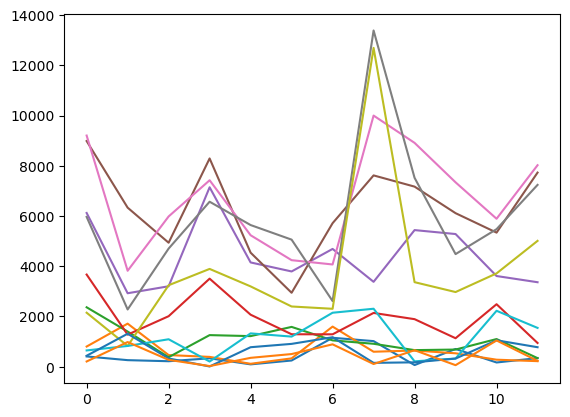

In [5]:
np.savetxt(cdf_folder+"deep_particles_count.csv", deep_count, delimiter=',', header="rows: years, columns: months")
plt.plot(deep_count)

In [39]:

# shallow_all_CDFs = np.zeros((len(months), t_days+1))
# deep_all_CDFs = np.zeros((len(months), t_days+1))
   
# shallow_all_CDFs[index, :], _ = utils.get_diff_CDF_PDF(all_sep_array[shallow_indices, :, index], threshold_dist, t_days)
# deep_all_CDFs[index, :], _ = utils.get_diff_CDF_PDF(all_sep_array[indices, :, index], threshold_dist, t_days)
    

Discarded:  165
Discarded:  0


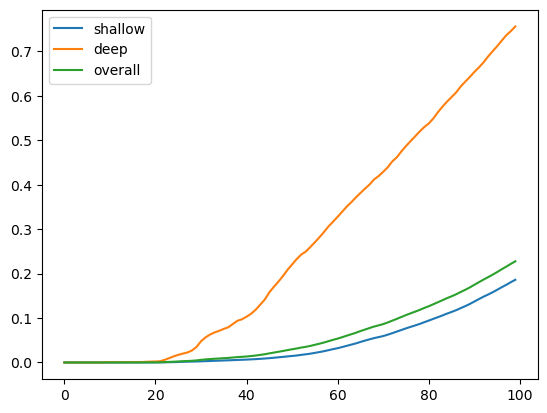

In [44]:
plt.plot(shallow_all_CDFs[0,:-1], label='shallow')
plt.plot(deep_all_CDFs[0,:-1], label='deep')
plt.plot(all_CDFs[0,:-1], label='overall')
plt.legend()